In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gzip 
# Input data files are available in the "../input/" directory.
# For preprocessing
from sklearn import preprocessing

import os
# print(os.listdir('../'))
# print(os.listdir("../input"))
print("pandas: {}".format(pd.__version__))
print('numpy: {}'.format(np.__version__))
# Any results you write to the current directory are saved as output.

pandas: 0.24.2
numpy: 1.16.2


In [6]:
FOLDER = '/home/pibieta/Data/Future-Sales/'
print(os.listdir(FOLDER))

['item_categories.csv', 'shops.csv', 'items.csv', 'sample_submission.csv.gz', 'test.csv.gz', 'sales_train.csv.gz']


In [16]:
%%timeit
shops_df = pd.read_csv(FOLDER + '/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})  
                            # col'umns: ['shop_name','shop_id']
item_cat_df = pd.read_csv(FOLDER+'/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'}) 
items_df = pd.read_csv(FOLDER + '/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})  
                            # ['item_name','item_id','item_category_id']                            # columns: ['item_category_name', 'item_category_id']
sales_train_df  = pd.read_csv(FOLDER + '/sales_train.csv.gz', compression = 'gzip', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'}) 
                            # ['date','date_block_num','shop_id','item_id','item_price', 'item_cnt_day']

    
sample_sub_df = pd.read_csv(FOLDER+'/sample_submission.csv.gz', compression = 'gzip')  # ['ID',item_cnt_month']
test_df = pd.read_csv(FOLDER+'/test.csv.gz', compression = 'gzip',dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}) # [shop_id','item_id']

3min 11s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
test_df = pd.read_csv(FOLDER+'/test.csv.gz', compression = 'gzip',dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}) # [shop_id','item_id']

In [24]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Pipeline:
1. Eliminate Outliers from the train set.
2. Perform Feature Engineering.
3. Merge with the test_df to include **missing values**.
4. Construct the final train dataset, this is, properly fill **missing values**.
5. Play with models.


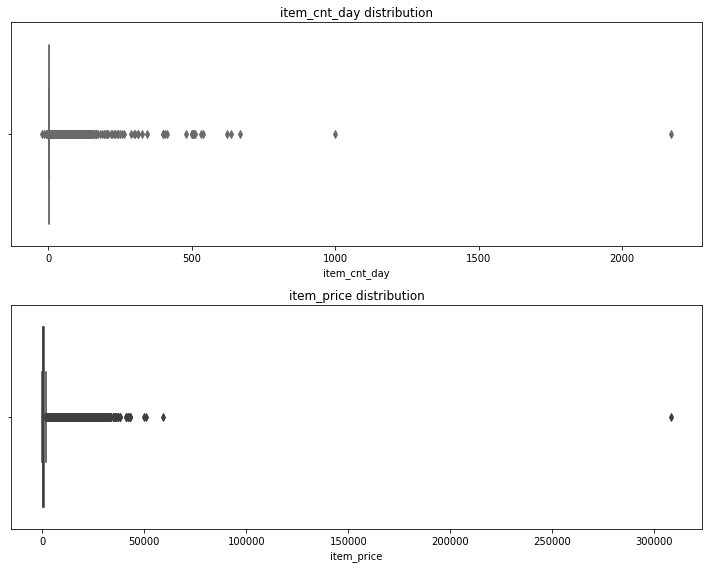

In [19]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
# plt.figure(figsize=(10,4))
# plt.xlim(-100, 3000)
sns.boxplot(x=sales_train_df['item_cnt_day'], ax =ax[0], palette='Set3' ).set_title('item_cnt_day distribution')
# plt.figure(figsize=(10,4))
# plt.xlim(sales_train_df['item_price'].min(), sales_train_df['item_price'].max())
sns.boxplot(x=sales_train_df['item_price'], ax = ax[1] ).set_title('item_price distribution')
plt.tight_layout()
plt.show()

In [25]:
# There are repeated shops with different id let's correct this
# Якутск Орджоникидзе, 56
sales_train_df.loc[sales_train_df.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train_df.loc[sales_train_df.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train_df.loc[sales_train_df.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11

In [26]:
# Remove outliers
train_0 = sales_train_df.query('item_cnt_day > 0 and item_cnt_day <= 400 and item_price <= 40000')

## Blank dataset
It contains all `['shop_id', 'item_id']` pairs, this will the starting point of our dataset

In [28]:
%%timeit
items_notin_train = test_df[~test_df['item_id'].isin(train_0['item_id'])]['item_id'].unique()
all_items = np.concatenate((train_0['item_id'].unique(),items_notin_train))
all_shops = train_0['shop_id'].unique()
blank_df = []
for i in range(34):
    for shop in all_shops:
        for item in all_items:
            blank_df.append([i, shop, item])
    
blank_df = pd.DataFrame(blank_df, columns=['date_block_num','shop_id','item_id'])

MemoryError: 